In [21]:
from datetime import datetime, timedelta
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation, performance_metrics
from fbprophet.plot import plot_cross_validation_metric
from IPython.core.display import clear_output
from IPython.display import Image  
from math import sqrt
from matplotlib.pylab import rcParams
from pandas import DataFrame
from pmdarima.arima import auto_arima, ARIMA
from pmdarima.model_selection import train_test_split
from pmdarima.pipeline import Pipeline
from pmdarima.preprocessing import BoxCoxEndogTransformer
from pprint import pprint
from pylab import rcParams
from scipy import stats
from sklearn import metrics
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.externals.six import StringIO  
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, confusion_matrix, explained_variance_score, mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import cross_val_predict, cross_val_score, GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from statistics import mean
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from subprocess import call
from termcolor import colored
from time import sleep
from tqdm import tqdm, tqdm_notebook
from tqdm.notebook import trange, tqdm, tnrange
from xgboost import plot_importance, plot_tree, XGBClassifier
from xgboost.sklearn import XGBClassifier
import datetime as dt
import getpass
import graphviz
import itertools
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import pmdarima as pm
import pycountry
import pycountry_convert as pc
import pydotplus
import pyodbc 
import seaborn as sns
import sklearn.linear_model as lm
import statsmodels.api as sm
import warnings
import xgboost as xgb
pd.options.display.float_format = '{:.2f}'.format   
pd.plotting.register_matplotlib_converters()
warnings.filterwarnings('ignore')
rcParams['figure.figsize'] = 15, 5

## Data load

In [53]:
url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
df = pd.read_csv(url)
df = pd.melt(df, id_vars=['Province/State', 'Country/Region','Lat','Long'], var_name='Date', value_name='Confirmed')
df['Date'] = pd.to_datetime(df['Date'])
df.head(5)

,Province/State,Country/Region,Lat,Long,Date,Confirmed
0,NaN,Afghanistan,33.00,65.00,2020-01-22,0
1,NaN,Albania,41.15,20.17,2020-01-22,0
2,NaN,Algeria,28.03,1.66,2020-01-22,0
3,NaN,Andorra,42.51,1.52,2020-01-22,0
4,NaN,Angola,-11.20,17.87,2020-01-22,0


In [54]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19650 entries, 0 to 19649
Data columns (total 6 columns):
Province/State    6150 non-null object
Country/Region    19650 non-null object
Lat               19650 non-null float64
Long              19650 non-null float64
Date              19650 non-null datetime64[ns]
Confirmed         19650 non-null int64
dtypes: datetime64[ns](1), float64(2), int64(1), object(2)
memory usage: 921.2+ KB


In [55]:
df = df.rename(columns={'Province/State': 'Province', 'Country/Region': 'Country'})
df.shape

(19650, 6)

In [56]:
df['Province_and_country'] = df['Country'].map(str) + "_" + df['Province'].map(str)
df['Province_and_country'] = df['Province_and_country'].str.replace('_nan', '').map(str)

In [57]:
df['Days_since_outbreak_global'] = df.groupby(['Province_and_country','Lat','Long']).cumcount()+1

In [58]:
df.head()

,Province,Country,Lat,Long,Date,Confirmed,Province_and_country,Days_since_outbreak_global
0,NaN,Afghanistan,33.00,65.00,2020-01-22,0,Afghanistan,1
1,NaN,Albania,41.15,20.17,2020-01-22,0,Albania,1
2,NaN,Algeria,28.03,1.66,2020-01-22,0,Algeria,1
3,NaN,Andorra,42.51,1.52,2020-01-22,0,Andorra,1
4,NaN,Angola,-11.20,17.87,2020-01-22,0,Angola,1


In [59]:
df.to_csv('df_m.CSV',sep=',')

## Analysis - Amount of cases

In [29]:
len(df['Province_and_country'].unique())

262

In [30]:
len(df['Country'].unique())

183

In [31]:
len(df['Province'].unique())

83

In [32]:
df.describe()

,Lat,Long,Confirmed,Days_since_outbreak_global
count,19650.00,19650.00,19650.00,19650.00
mean,21.42,22.13,820.13,38.00
std,24.75,70.78,7728.16,21.65
min,-51.80,-135.00,0.00,1.00
25%,7.00,-23.04,0.00,19.00
50%,23.66,20.54,0.00,38.00
75%,41.20,81.00,55.00,57.00
max,71.71,178.06,337072.00,75.00


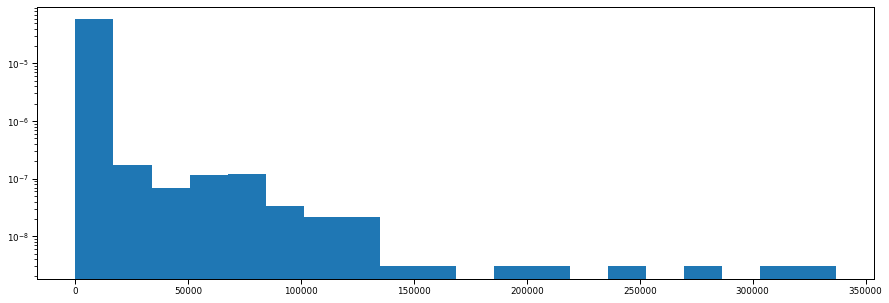

In [33]:
plt.hist(df['Confirmed'], density=True, bins=20) 
plt.yscale('log')

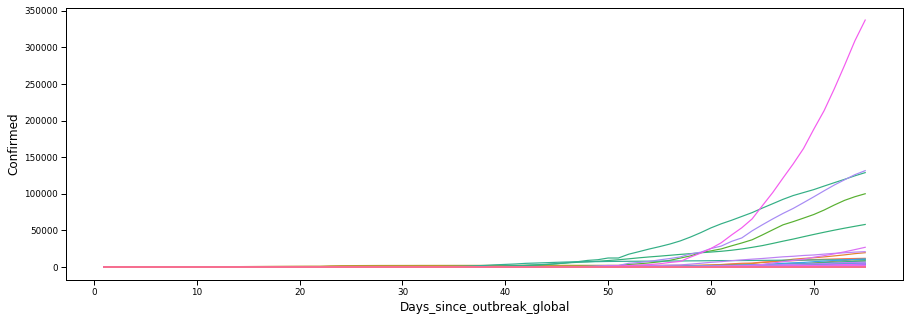

In [34]:
ax=sns.lineplot(data=df, hue="Country", x="Days_since_outbreak_global", y="Confirmed", ci=None)
ax.legend_.remove()

Days_since_outbreak_global  1   2   3   4   5   6   7   8   9   10  ...   66  \
Country                                                             ...        
Afghanistan                  0   0   0   0   0   0   0   0   0   0  ...  110   
Albania                      0   0   0   0   0   0   0   0   0   0  ...  186   
Algeria                      0   0   0   0   0   0   0   0   0   0  ...  409   
Andorra                      0   0   0   0   0   0   0   0   0   0  ...  267   
Angola                       0   0   0   0   0   0   0   0   0   0  ...    4   

Days_since_outbreak_global   67   68   69   70   71   72    73    74    75  
Country                                                                     
Afghanistan                 110  120  170  174  237  273   281   299   349  
Albania                     197  212  223  243  259  277   304   333   361  
Algeria                     454  511  584  716  847  986  1171  1251  1320  
Andorra                     308  334  370  376  390  4

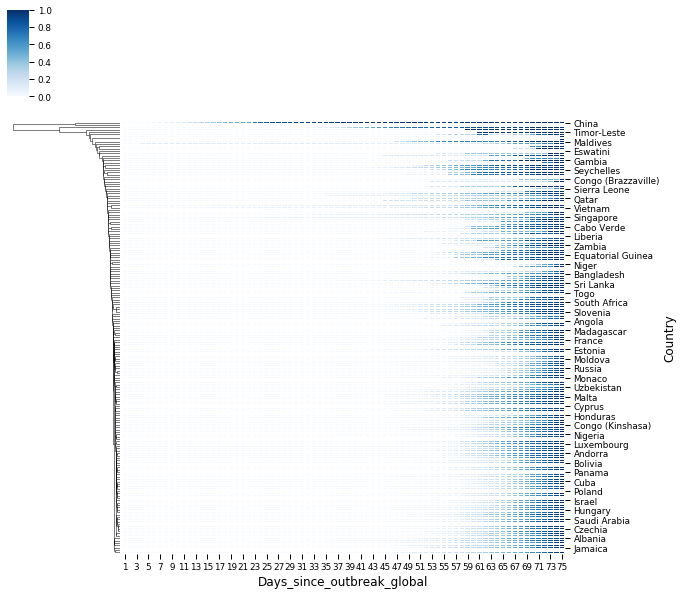

<Figure size 1800x576 with 0 Axes>

In [35]:
sns.set_context("paper", rc={"font.size":8,"axes.titlesize":12,"axes.labelsize":12})   
def group_and_chart(Geography, Figure, Data):
    grouped = Data.groupby(['Days_since_outbreak_global',Geography])[Figure].sum()
    grouped= pd.DataFrame(grouped) 
    grouped.reset_index(inplace=True)
    grouped=grouped.pivot(index='Days_since_outbreak_global', columns=Geography, values=Figure)
    grouped = grouped.T[(grouped != 0).any()].T
    grouped = grouped.transpose()
    grouped.fillna(0, inplace=True)
    print(grouped.head())
    sns.clustermap(grouped, cmap="Blues", linewidth=.5, standard_scale=0,  col_cluster=False, method='single')
    plt.figure(figsize=(25,8))
    
group_and_chart(Geography='Country', Figure='Confirmed', Data=df)

In [60]:
url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/UID_ISO_FIPS_LookUp_Table.csv'
df_country = pd.read_csv(url)
df_country = df_country.drop_duplicates(subset=['Country_Region'], keep=False)
df_country

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,Combined_Key
0,4,AF,AFG,4.00,nan,NaN,NaN,Afghanistan,33.94,67.71,Afghanistan
1,8,AL,ALB,8.00,nan,NaN,NaN,Albania,41.15,20.17,Albania
2,12,DZ,DZA,12.00,nan,NaN,NaN,Algeria,28.03,1.66,Algeria
3,20,AD,AND,20.00,nan,NaN,NaN,Andorra,42.51,1.52,Andorra
4,24,AO,AGO,24.00,nan,NaN,NaN,Angola,-11.20,17.87,Angola
...,...,...,...,...,...,...,...,...,...,...,...
172,704,VN,VNM,704.00,nan,NaN,NaN,Vietnam,14.06,108.28,Vietnam
173,275,PS,PSE,275.00,nan,NaN,NaN,West Bank and Gaza,31.95,35.23,West Bank and Gaza
174,732,EH,ESH,732.00,nan,NaN,NaN,Western Sahara,24.22,-12.89,Western Sahara
175,894,ZM,ZMB,894.00,nan,NaN,NaN,Zambia,-13.13,27.85,Zambia


In [61]:
# apply the mapping to df
df = pd.merge(df, df_country[['Country_Region','iso2']], left_on='Country', right_on='Country_Region', how='left')
df

,Province,Country,Lat,Long,Date,Confirmed,Province_and_country,Days_since_outbreak_global,Country_Region,iso2
0,NaN,Afghanistan,33.00,65.00,2020-01-22,0,Afghanistan,1,Afghanistan,AF
1,NaN,Albania,41.15,20.17,2020-01-22,0,Albania,1,Albania,AL
2,NaN,Algeria,28.03,1.66,2020-01-22,0,Algeria,1,Algeria,DZ
3,NaN,Andorra,42.51,1.52,2020-01-22,0,Andorra,1,Andorra,AD
4,NaN,Angola,-11.20,17.87,2020-01-22,0,Angola,1,Angola,AO
...,...,...,...,...,...,...,...,...,...,...
19645,NaN,Malawi,-13.25,34.30,2020-04-05,4,Malawi,75,NaN,NaN
19646,Falkland Islands (Islas Malvinas),United Kingdom,-51.80,-59.52,2020-04-05,2,United Kingdom_Falkland Islands (Islas Malvinas),75,NaN,NaN
19647,Saint Pierre and Miquelon,France,46.89,-56.32,2020-04-05,1,France_Saint Pierre and Miquelon,75,NaN,NaN
19648,NaN,South Sudan,6.88,31.31,2020-04-05,1,South Sudan,75,NaN,NaN


In [62]:
def alpha2_to_continent(iso):
    try: cont = pc.country_alpha2_to_continent_code(iso)
    except: cont = float('NaN')
    return cont

df['Continent'] = df['iso2'].apply(alpha2_to_continent) # get continent code

df.loc[df['Country'] == "Diamond Princess", 'Continent'] = "Diamond Princess"
df.loc[df['Country'] == "MS Zaandam", 'Continent'] = "MS Zaandam"
df.loc[df['Country'] == "Netherlands", 'Continent'] = "EU"
df.loc[df['Country'] == "Holy See", 'Continent'] = "AS"
df.loc[df['Country'] == "Namibia", 'Continent'] = "AF"
df.loc[df['Country'] == "Timor-Leste", 'Continent'] = "AS"
df.loc[df['Country'] == "Western Sahara", 'Continent'] = "AF"

df['Continent'] = df['Continent'].map({'MS Zaandam':'Ships','Diamond Princess':'Ships','AF':'Africa','AS':'Asia','EU':'Europe','NA':'North America','OC':'Oceania','SA':'South America'})

Days_since_outbreak_global  1   2   3   4   5   6   7   8   9   10  ...  \
Continent                                                           ...   
Africa                       0   0   0   0   0   0   0   0   0   0  ...   
Asia                         6  10  17  23  30  35  49  56  67  87  ...   
Europe                       0   0   0   0   0   1   4   5   5  11  ...   
North America                0   0   0   0   0   0   0   0   0   0  ...   
Oceania                      0   0   0   0   0   0   0   0   0   0  ...   

Days_since_outbreak_global      66      67      68      69      70      71  \
Continent                                                                    
Africa                        3885    4225    4786    5196    5781    6380   
Asia                         66072   73324   80547   87472   96180  104643   
Europe                      269205  298397  322586  346247  370517  397564   
North America                 2461    2969    3443    3819    4372    4773   
Oceani

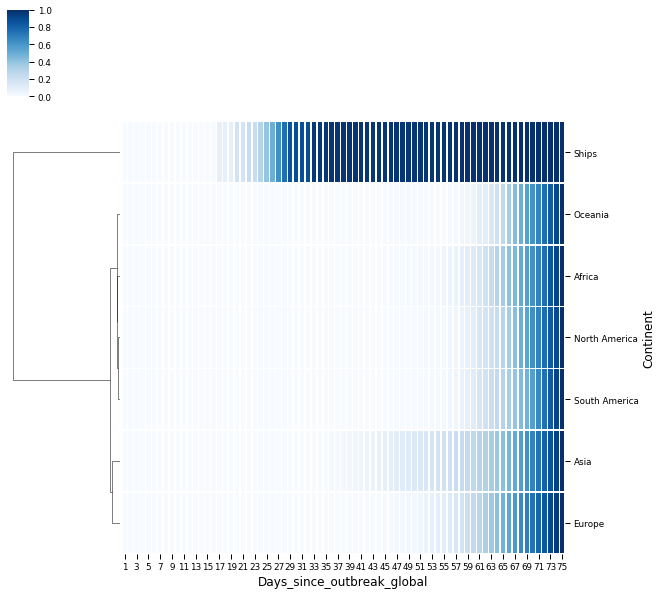

<Figure size 1800x576 with 0 Axes>

In [63]:
group_and_chart(Geography='Continent', Figure='Confirmed', Data=df)

Days_since_outbreak_global  1   2   3   4   5   6   7   8   9   10  ...   66  \
Country                                                             ...        
Afghanistan                  0   0   0   0   0   0   0   0   0   0  ...  110   
Armenia                      0   0   0   0   0   0   0   0   0   0  ...  329   
Azerbaijan                   0   0   0   0   0   0   0   0   0   0  ...  165   
Bahrain                      0   0   0   0   0   0   0   0   0   0  ...  466   
Bangladesh                   0   0   0   0   0   0   0   0   0   0  ...   48   

Days_since_outbreak_global   67   68   69   70   71   72   73   74   75  
Country                                                                  
Afghanistan                 110  120  170  174  237  273  281  299  349  
Armenia                     407  424  482  532  571  663  736  770  822  
Azerbaijan                  182  209  273  298  359  400  443  521  584  
Bahrain                     476  499  515  567  569  643  672  688  7

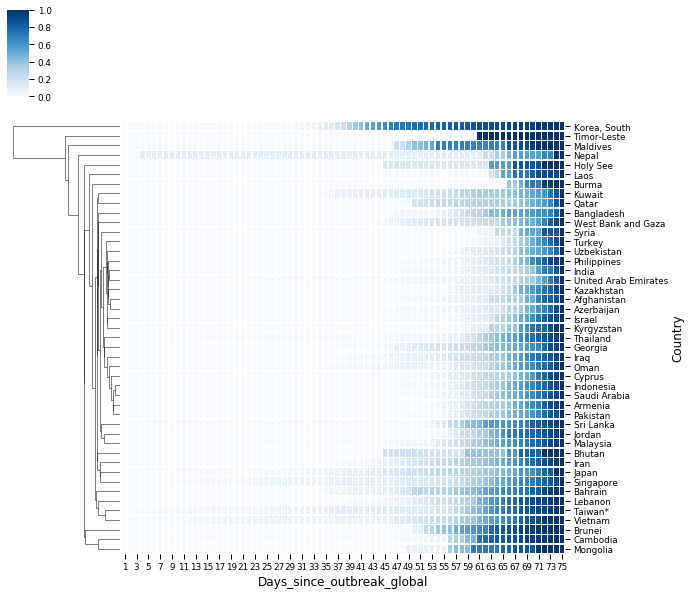

<Figure size 1800x576 with 0 Axes>

In [64]:
df_ = df.loc[(df.Continent == 'Asia')]
group_and_chart(Geography='Country', Figure='Confirmed', Data=df_)

Days_since_outbreak_global  1   2   3   4   5   6   7   8   9   10  ...    66  \
Country                                                             ...         
Albania                      0   0   0   0   0   0   0   0   0   0  ...   186   
Andorra                      0   0   0   0   0   0   0   0   0   0  ...   267   
Austria                      0   0   0   0   0   0   0   0   0   0  ...  7657   
Belarus                      0   0   0   0   0   0   0   0   0   0  ...    94   
Belgium                      0   0   0   0   0   0   0   0   0   0  ...  7284   

Days_since_outbreak_global    67     68     69     70     71     72     73  \
Country                                                                      
Albania                      197    212    223    243    259    277    304   
Andorra                      308    334    370    376    390    428    439   
Austria                     8271   8788   9618  10180  10711  11129  11524   
Belarus                       94     94   

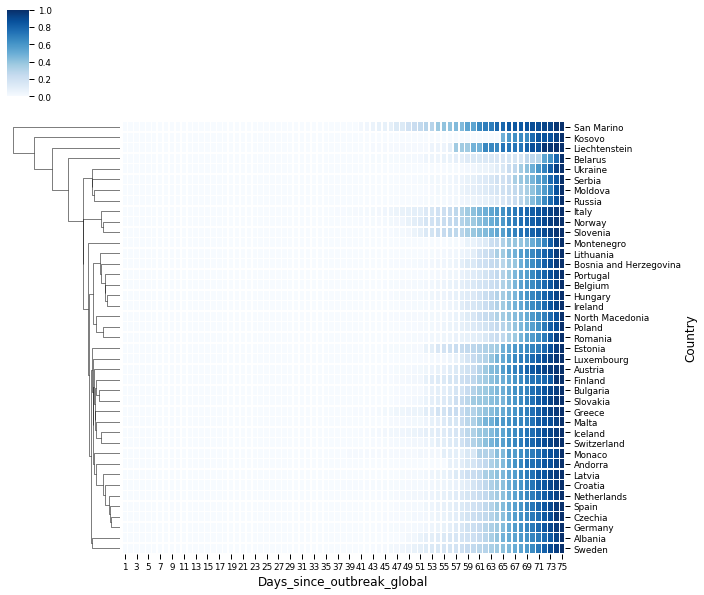

<Figure size 1800x576 with 0 Axes>

In [65]:
df_ = df.loc[(df.Continent == 'Europe')]
group_and_chart(Geography='Country', Figure='Confirmed', Data=df_)

Days_since_outbreak_global  1   2   3   4   5   6   7   8   9   10  ...   66  \
Country                                                             ...        
Algeria                      0   0   0   0   0   0   0   0   0   0  ...  409   
Angola                       0   0   0   0   0   0   0   0   0   0  ...    4   
Benin                        0   0   0   0   0   0   0   0   0   0  ...    6   
Botswana                     0   0   0   0   0   0   0   0   0   0  ...    0   
Burkina Faso                 0   0   0   0   0   0   0   0   0   0  ...  180   

Days_since_outbreak_global   67   68   69   70   71   72    73    74    75  
Country                                                                     
Algeria                     454  511  584  716  847  986  1171  1251  1320  
Angola                        5    7    7    7    8    8     8    10    14  
Benin                         6    6    6    9   13   13    16    16    22  
Botswana                      0    0    3    4    4   

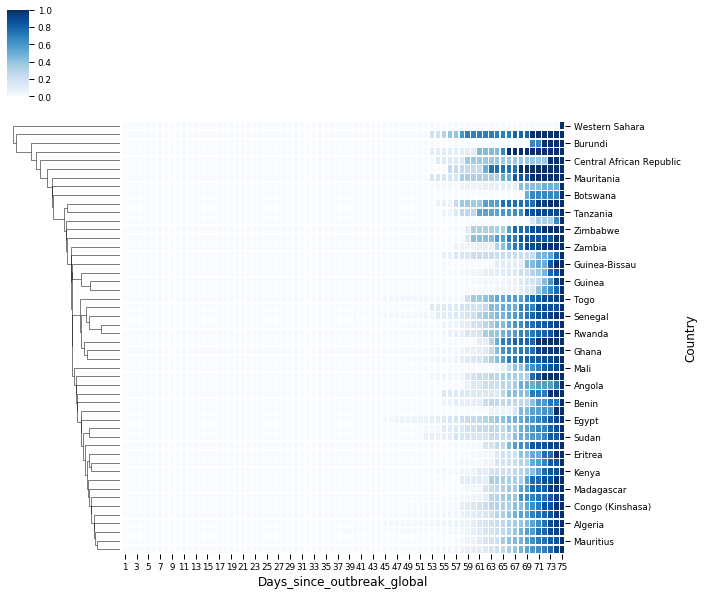

<Figure size 1800x576 with 0 Axes>

In [66]:
df_ = df.loc[(df.Continent == 'Africa')]
group_and_chart(Geography='Country', Figure='Confirmed', Data=df_)

Days_since_outbreak_global  1   2   3   4   5   6   7   8   9   10  ...   66  \
Country                                                             ...        
Antigua and Barbuda          0   0   0   0   0   0   0   0   0   0  ...    7   
Bahamas                      0   0   0   0   0   0   0   0   0   0  ...   10   
Barbados                     0   0   0   0   0   0   0   0   0   0  ...   24   
Belize                       0   0   0   0   0   0   0   0   0   0  ...    2   
Costa Rica                   0   0   0   0   0   0   0   0   0   0  ...  263   

Days_since_outbreak_global   67   68   69   70   71   72   73   74   75  
Country                                                                  
Antigua and Barbuda           7    7    7    7    7    9   15   15   15  
Bahamas                      10   11   14   14   21   24   24   28   28  
Barbados                     26   33   33   34   34   46   51   52   56  
Belize                        2    2    3    3    3    3    4    4   

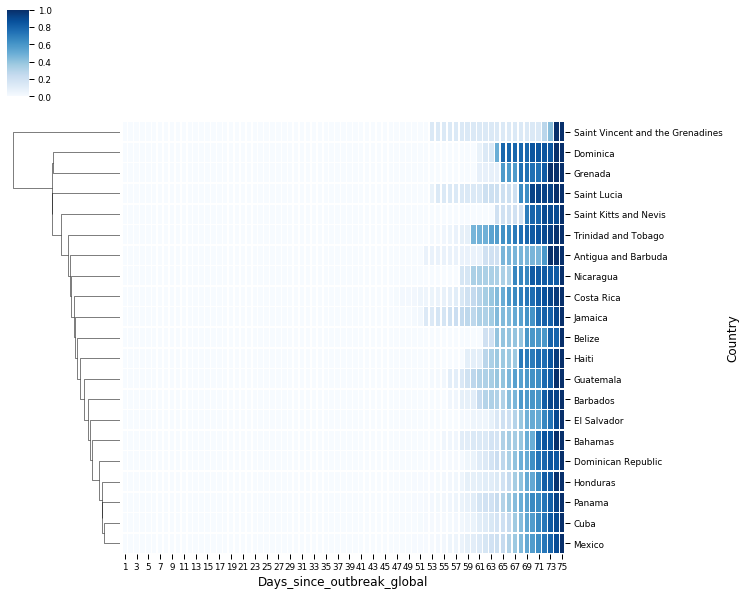

<Figure size 1800x576 with 0 Axes>

In [67]:
df_ = df.loc[(df.Continent == 'North America')]
group_and_chart(Geography='Country', Figure='Confirmed', Data=df_)

Days_since_outbreak_global  1   2   3   4   5   6   7   8   9   10  ...   66  \
Country                                                             ...        
Fiji                         0   0   0   0   0   0   0   0   0   0  ...    5   
New Zealand                  0   0   0   0   0   0   0   0   0   0  ...  368   
Papua New Guinea             0   0   0   0   0   0   0   0   0   0  ...    1   

Days_since_outbreak_global   67   68   69   70   71   72   73   74    75  
Country                                                                   
Fiji                          5    5    5    5    5    7    7   12    12  
New Zealand                 451  514  589  647  708  797  868  950  1039  
Papua New Guinea              1    1    1    1    1    1    1    1     1  

[3 rows x 75 columns]


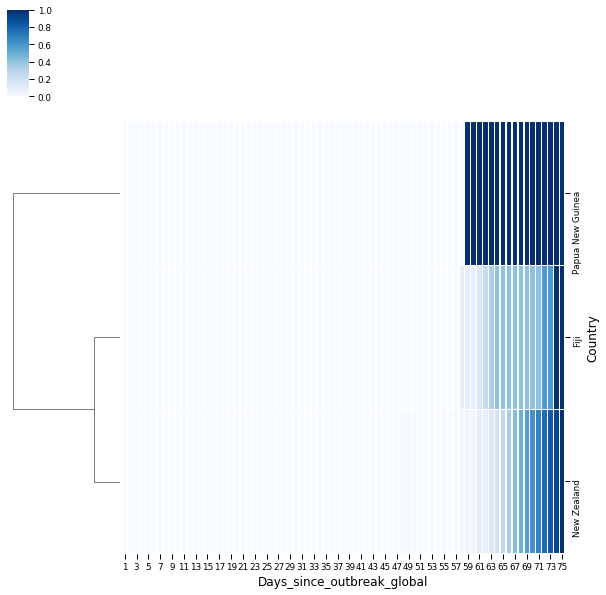

<Figure size 1800x576 with 0 Axes>

In [68]:
df_ = df.loc[(df.Continent == 'Oceania')]
group_and_chart(Geography='Country', Figure='Confirmed', Data=df_)

Days_since_outbreak_global  1   2   3   4   5   6   7   8   9   10  ...    66  \
Country                                                             ...         
Argentina                    0   0   0   0   0   0   0   0   0   0  ...   589   
Bolivia                      0   0   0   0   0   0   0   0   0   0  ...    61   
Brazil                       0   0   0   0   0   0   0   0   0   0  ...  3417   
Chile                        0   0   0   0   0   0   0   0   0   0  ...  1610   
Colombia                     0   0   0   0   0   0   0   0   0   0  ...   539   

Days_since_outbreak_global    67    68    69    70    71    72    73     74  \
Country                                                                       
Argentina                    690   745   820  1054  1054  1133  1265   1451   
Bolivia                       74    81    97   107   115   123   132    139   
Brazil                      3904  4256  4579  5717  6836  8044  9056  10360   
Chile                       1909  213

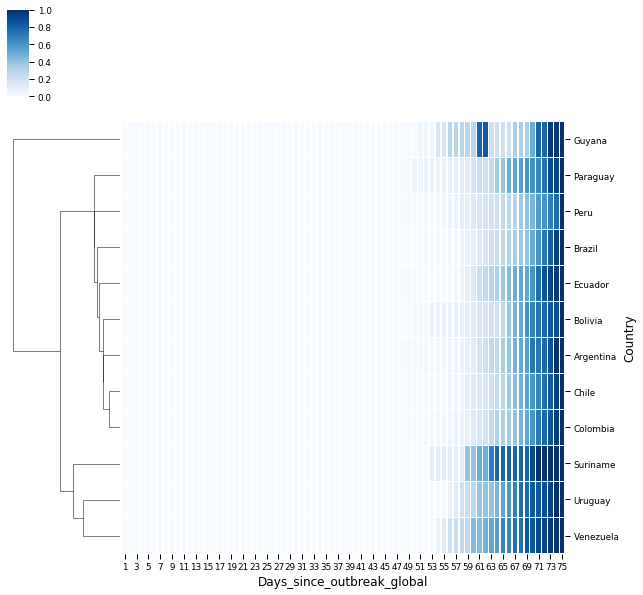

<Figure size 1800x576 with 0 Axes>

In [69]:
df_ = df.loc[(df.Continent == 'South America')]
group_and_chart(Geography='Country', Figure='Confirmed', Data=df_)

## Analysis - daily increase

In [70]:
df['Day'] = df['Date'].dt.day
df['Weekday'] = df['Date'].dt.weekday
df['Week_number'] = df['Date'].dt.week
df['Quarter'] = df['Date'].dt.quarter
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year
df['Confirmed_lag_1'] = df.groupby('Province_and_country')['Confirmed'].shift(1)
df['Daily_increase_confirmed'] = (df['Confirmed']/df['Confirmed_lag_1'])-1
df = df.replace([np.inf, -np.inf], np.nan)
#df.loc[df['Daily_increase_confirmed'] == np.inf, 'Daily_increase_confirmed'] = df['Confirmed']
#df.loc[df['Daily_increase_death'] == np.inf, 'Daily_increase_death'] = df['Deaths']
df = df.replace(np.nan, 0)
df

,Province,Country,Lat,Long,Date,Confirmed,Province_and_country,Days_since_outbreak_global,Country_Region,iso2,Continent,Day,Weekday,Week_number,Quarter,Month,Year,Confirmed_lag_1,Daily_increase_confirmed
0,0,Afghanistan,33.00,65.00,2020-01-22,0,Afghanistan,1,Afghanistan,AF,Asia,22,2,4,1,1,2020,0.00,0.00
1,0,Albania,41.15,20.17,2020-01-22,0,Albania,1,Albania,AL,Europe,22,2,4,1,1,2020,0.00,0.00
2,0,Algeria,28.03,1.66,2020-01-22,0,Algeria,1,Algeria,DZ,Africa,22,2,4,1,1,2020,0.00,0.00
3,0,Andorra,42.51,1.52,2020-01-22,0,Andorra,1,Andorra,AD,Europe,22,2,4,1,1,2020,0.00,0.00
4,0,Angola,-11.20,17.87,2020-01-22,0,Angola,1,Angola,AO,Africa,22,2,4,1,1,2020,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19645,0,Malawi,-13.25,34.30,2020-04-05,4,Malawi,75,0,0,0,5,6,14,2,4,2020,4.00,0.00
19646,Falkland Islands (Islas Malvinas),United Kingdom,-51.80,-59.52,2020-04-05,2,United Kingdom_Falkland Islands (Islas Malvinas),75,0,0,0,5,6,14,2,4,2020,1.00,1.00
19647,Saint Pierre and Miquelon,France,46.89,-56.32,2020-04-05,1,France_Saint Pierre and Miquelon,75,0,0,0,5,6,14,2,4,2020,0.00,0.00
19648,0,South Sudan,6.88,31.31,2020-04-05,1,South Sudan,75,0,0,0,5,6,14,2,4,2020,0.00,0.00


In [71]:
df.to_csv('df_m.CSV',sep=',')

Days_since_outbreak_global   1    2    3    4    5    6    7    8    9    10  \
Country                                                                        
Afghanistan                0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Albania                    0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Algeria                    0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Andorra                    0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Angola                     0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   

Days_since_outbreak_global  ...   66   67   68   69   70   71   72   73   74  \
Country                     ...                                                
Afghanistan                 ... 0.17 0.00 0.09 0.42 0.02 0.36 0.15 0.03 0.06   
Albania                     ... 0.07 0.06 0.08 0.05 0.09 0.07 0.07 0.10 0.10   
Algeria                     ... 0.11 0.11 0.13 0.14 0.23 0.18 0.16 0.19 0.07   
Andorra                     ... 0.19 0.

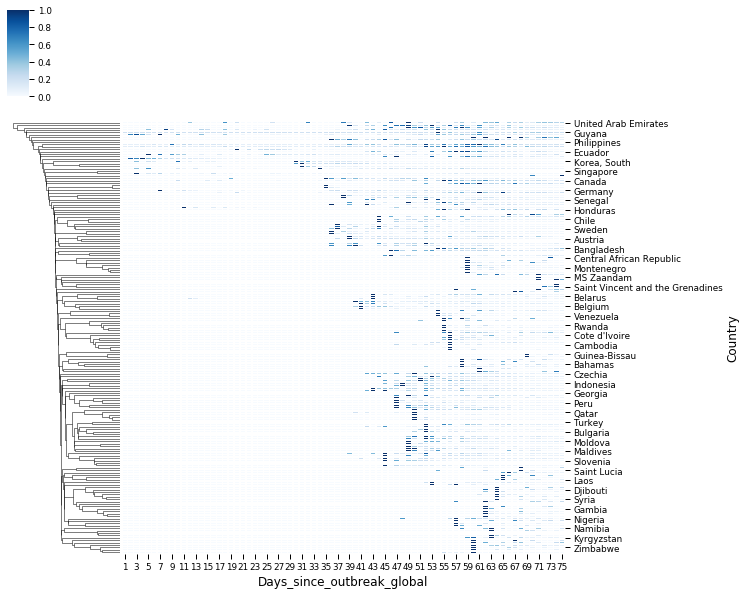

<Figure size 1800x576 with 0 Axes>

In [72]:
group_and_chart(Geography='Country', Figure='Daily_increase_confirmed', Data=df)

Days_since_outbreak_global   1     2     3     4     5     6     7    8   \
Continent                                                                  
0                          0.00 32.38 26.95 39.61 18.80 19.53 13.51 6.98   
Africa                     0.00  0.00  0.00  0.00  0.00  0.00  0.00 0.00   
Asia                       0.00  0.50  5.67  0.40  2.64  0.83  2.50 0.75   
Europe                     0.00  0.00  0.00  0.00  0.00  0.00  3.00 0.00   
North America              0.00  0.00  0.00  0.00  0.00  0.00  0.00 0.00   

Days_since_outbreak_global    9    10  ...   66   67    68   69   70   71  \
Continent                              ...                                  
0                          10.78 9.82  ... 7.23 6.59  3.56 6.26 4.60 5.19   
Africa                      0.00 0.00  ... 8.13 7.55 13.51 7.39 8.12 8.25   
Asia                        1.27 2.88  ... 5.82 5.11  5.57 3.77 3.60 3.82   
Europe                      0.00 0.25  ... 6.70 5.12  5.11 4.22 4.02 5.20   
North

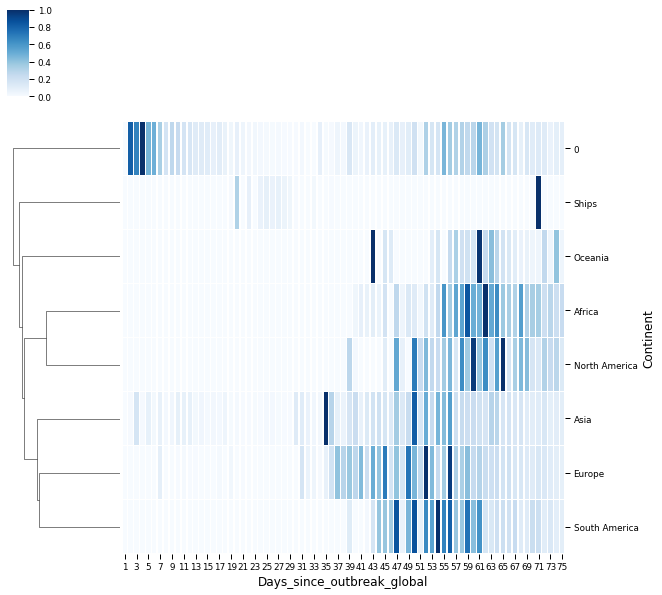

<Figure size 1800x576 with 0 Axes>

In [73]:
group_and_chart(Geography='Continent', Figure='Daily_increase_confirmed', Data=df)

Days_since_outbreak_global   1    2    3    4    5    6    7    8    9    10  \
Country                                                                        
Afghanistan                0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Armenia                    0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Azerbaijan                 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Bahrain                    0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Bangladesh                 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   

Days_since_outbreak_global  ...   66   67   68   69   70   71   72   73   74  \
Country                     ...                                                
Afghanistan                 ... 0.17 0.00 0.09 0.42 0.02 0.36 0.15 0.03 0.06   
Armenia                     ... 0.13 0.24 0.04 0.14 0.10 0.07 0.16 0.11 0.05   
Azerbaijan                  ... 0.35 0.10 0.15 0.31 0.09 0.20 0.11 0.11 0.18   
Bahrain                     ... 0.02 0.

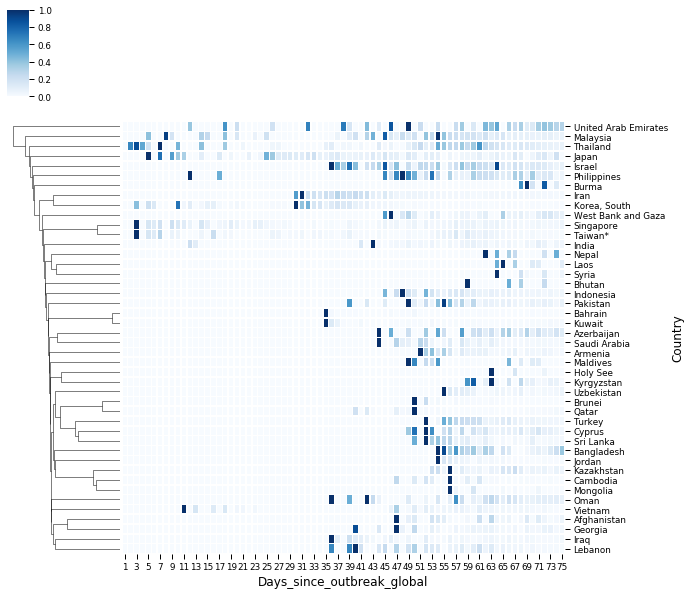

<Figure size 1800x576 with 0 Axes>

In [74]:
df_ = df.loc[(df.Continent == 'Asia')]
group_and_chart(Geography='Country', Figure='Daily_increase_confirmed', Data=df_)

Days_since_outbreak_global   1    2    3    4    5    6    7    8    9    10  \
Country                                                                        
Albania                    0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Andorra                    0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Austria                    0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Belarus                    0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Belgium                    0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   

Days_since_outbreak_global  ...   66   67   68   69   70   71   72   73   74  \
Country                     ...                                                
Albania                     ... 0.07 0.06 0.08 0.05 0.09 0.07 0.07 0.10 0.10   
Andorra                     ... 0.19 0.15 0.08 0.11 0.02 0.04 0.10 0.03 0.06   
Austria                     ... 0.11 0.08 0.06 0.09 0.06 0.05 0.04 0.04 0.02   
Belarus                     ... 0.09 0.

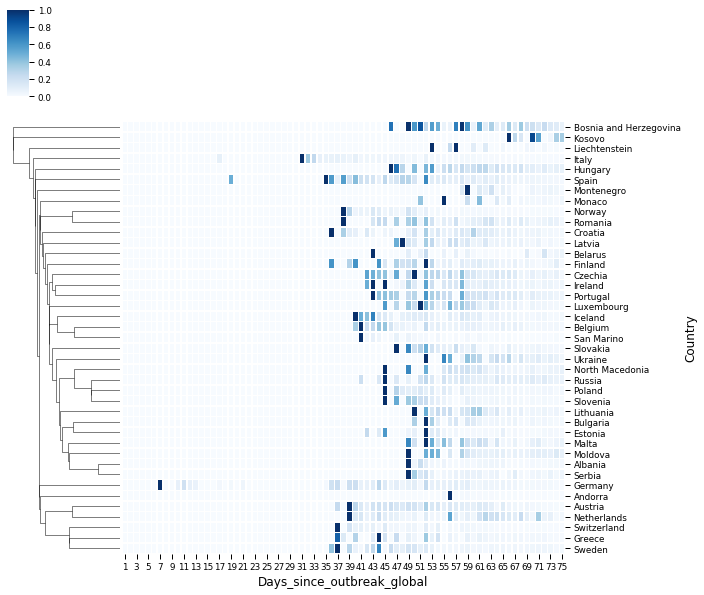

<Figure size 1800x576 with 0 Axes>

In [75]:
df_ = df.loc[(df.Continent == 'Europe')]
group_and_chart(Geography='Country', Figure='Daily_increase_confirmed', Data=df_)

Days_since_outbreak_global   1    2    3    4    5    6    7    8    9    10  \
Country                                                                        
Algeria                    0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Angola                     0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Benin                      0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Botswana                   0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Burkina Faso               0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   

Days_since_outbreak_global  ...   66   67   68   69   70   71   72   73   74  \
Country                     ...                                                
Algeria                     ... 0.11 0.11 0.13 0.14 0.23 0.18 0.16 0.19 0.07   
Angola                      ... 0.00 0.25 0.40 0.00 0.00 0.14 0.00 0.00 0.25   
Benin                       ... 0.00 0.00 0.00 0.00 0.50 0.44 0.00 0.23 0.00   
Botswana                    ... 0.00 0.

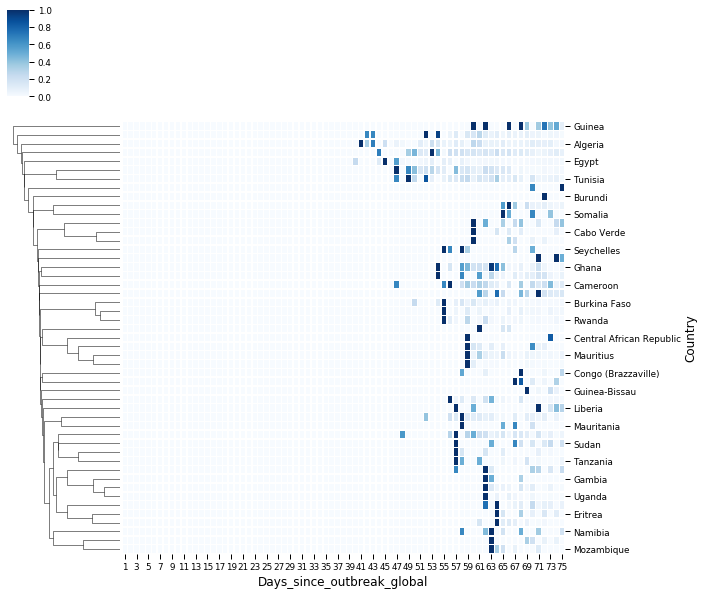

<Figure size 1800x576 with 0 Axes>

In [76]:
df_ = df.loc[(df.Continent == 'Africa')]
group_and_chart(Geography='Country', Figure='Daily_increase_confirmed', Data=df_)

Days_since_outbreak_global   1    2    3    4    5    6    7    8    9    10  \
Country                                                                        
Antigua and Barbuda        0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Bahamas                    0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Barbados                   0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Belize                     0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Costa Rica                 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   

Days_since_outbreak_global  ...   66   67   68   69   70   71   72   73   74  \
Country                     ...                                                
Antigua and Barbuda         ... 0.00 0.00 0.00 0.00 0.00 0.00 0.29 0.67 0.00   
Bahamas                     ... 0.11 0.00 0.10 0.27 0.00 0.50 0.14 0.00 0.17   
Barbados                    ... 0.33 0.08 0.27 0.00 0.03 0.00 0.35 0.11 0.02   
Belize                      ... 0.00 0.

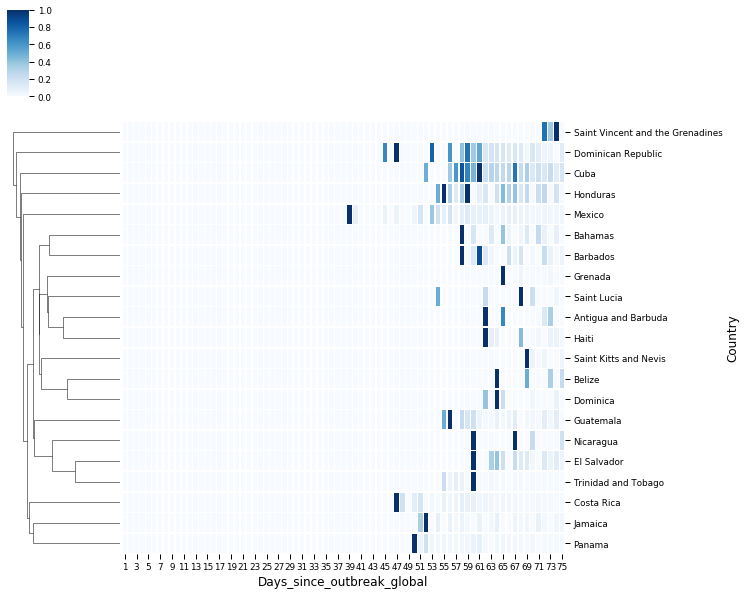

<Figure size 1800x576 with 0 Axes>

In [77]:
df_ = df.loc[(df.Continent == 'North America')]
group_and_chart(Geography='Country', Figure='Daily_increase_confirmed', Data=df_)

Days_since_outbreak_global   1    2    3    4    5    6    7    8    9    10  \
Country                                                                        
Fiji                       0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
New Zealand                0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   

Days_since_outbreak_global  ...   66   67   68   69   70   71   72   73   74  \
Country                     ...                                                
Fiji                        ... 0.00 0.00 0.00 0.00 0.00 0.00 0.40 0.00 0.71   
New Zealand                 ... 0.30 0.23 0.14 0.15 0.10 0.09 0.13 0.09 0.09   

Days_since_outbreak_global   75  
Country                          
Fiji                       0.00  
New Zealand                0.09  

[2 rows x 75 columns]


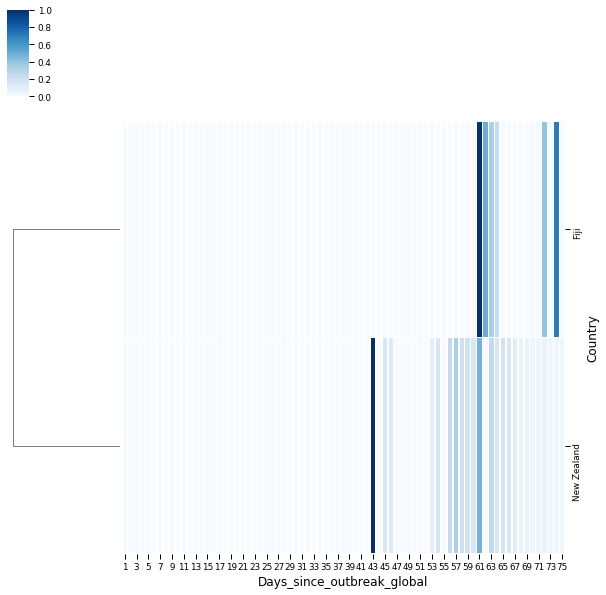

<Figure size 1800x576 with 0 Axes>

In [78]:
df_ = df.loc[(df.Continent == 'Oceania')]
group_and_chart(Geography='Country', Figure='Daily_increase_confirmed', Data=df_)

Days_since_outbreak_global   1    2    3    4    5    6    7    8    9    10  \
Country                                                                        
Argentina                  0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Bolivia                    0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Brazil                     0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Chile                      0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
Colombia                   0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   

Days_since_outbreak_global  ...   66   67   68   69   70   71   72   73   74  \
Country                     ...                                                
Argentina                   ... 0.17 0.17 0.08 0.10 0.29 0.00 0.07 0.12 0.15   
Bolivia                     ... 0.42 0.21 0.09 0.20 0.10 0.07 0.07 0.07 0.05   
Brazil                      ... 0.14 0.14 0.09 0.08 0.25 0.20 0.18 0.13 0.14   
Chile                       ... 0.23 0.

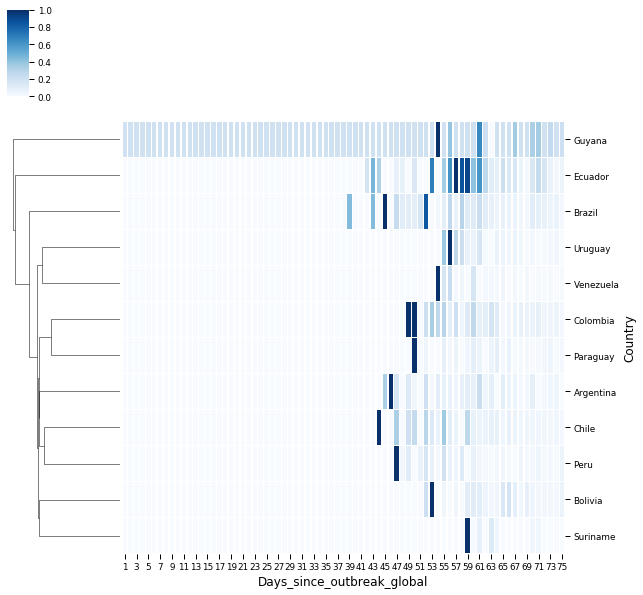

<Figure size 1800x576 with 0 Axes>

In [79]:
df_ = df.loc[(df.Continent == 'South America')]
group_and_chart(Geography='Country', Figure='Daily_increase_confirmed', Data=df_)

## Prediction

In [86]:
#Confirmed
df_ml_confirmed = df
df_ml_confirmed['Confirmed_lag_7'] = df_ml_confirmed.groupby('Province_and_country')['Confirmed'].shift(7)
df_ml_confirmed['Days_since_outbreak_country'] = df_ml_confirmed.loc[(df_ml_confirmed.Confirmed.notnull())].groupby(['Province_and_country','Lat','Long']).cumcount()+1
df_ml_confirmed = df_ml_confirmed.replace(np.nan, 0)
df_ml_confirmed = df_ml_confirmed[['Confirmed', 'Province_and_country', 'Days_since_outbreak_global', 'Date','Day','Weekday','Week_number','Quarter','Month','Year', 'Confirmed_lag_7','Days_since_outbreak_country']]

In [87]:
df_ml_confirmed.to_csv('df_ml.CSV',sep=',')

### One Country Test

In [88]:
split_date = datetime.today() - timedelta(days=8)
split_date

datetime.datetime(2020, 3, 29, 19, 48, 6, 196080)

In [89]:
def create_x_y(df, label=None):
    df.index = df['Date']
    X = df[['Days_since_outbreak_global','Day','Weekday','Week_number','Quarter','Month','Year', 'Confirmed_lag_7','Days_since_outbreak_country']]
    if label:
        y = df[label]
        return X, y
    return X

28990.59209802571
170.26623886732716
2.5056173761343508


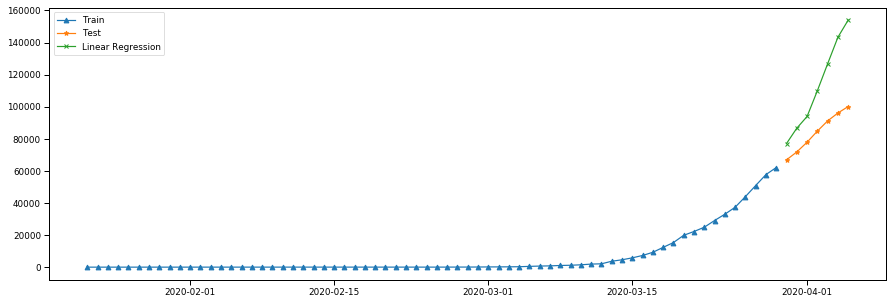

In [90]:
def SDMAE(y_true, y_pred): 
    return mean_absolute_error(y_true, y_pred) / np.std(y_true)

List = df_ml_confirmed.loc[(df_ml_confirmed.Province_and_country == "Germany")]
 
Confirmed_train = List.loc[List.Date <= split_date].copy()
Confirmed_test = List.loc[List.Date > split_date].copy()

X_train, y_train = create_x_y(Confirmed_train, label='Confirmed')
X_test, y_test = create_x_y(Confirmed_test, label='Confirmed')

X_train = X_train.fillna(0)
X_test = X_test.fillna(0)

linear_regressor = LinearRegression(fit_intercept=False)  # create object for the class

linear_regressor.fit(X_train, y_train)

Confirmed_test['Confirmed_Prediction'] = linear_regressor.predict(X_test)

plt.plot(Confirmed_train.index, Confirmed_train['Confirmed'], label='Train',marker ='^')
plt.plot(Confirmed_test.index, Confirmed_test['Confirmed'], label='Test', marker = "*")
plt.plot(Confirmed_test.index, Confirmed_test['Confirmed_Prediction'], label='Linear Regression', marker = "x")
plt.legend(loc='best')

print(mean_absolute_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed']))
print(np.sqrt(mean_absolute_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed'])))
print(SDMAE(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed']))

1998.857859602907
44.70858820856354
0.17275856141568202


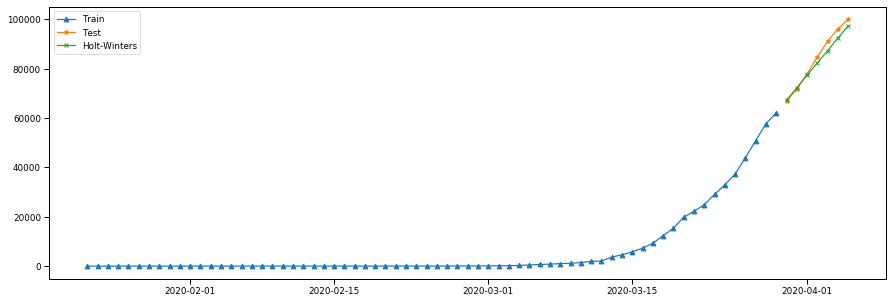

In [91]:
def SDMAE(y_true, y_pred): 
    return mean_absolute_error(y_true, y_pred) / np.std(y_true)

List = df_ml_confirmed.loc[(df_ml_confirmed.Province_and_country == "Germany")]

List.index = List['Date']
#List = List.reset_index(drop=True)

train = List.loc[List.Date <= split_date]
test = List.loc[List.Date > split_date]

train = train.fillna(0)
test = test.fillna(0)

train = pd.DataFrame(train['Confirmed'])
test = pd.DataFrame(test['Confirmed'])

model = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=12, damped=False) #base_model

hw_model = model.fit(optimized=True, use_boxcox=False, remove_bias=True) #base_model

pred = hw_model.predict(start=test.index[0], end=test.index[-1])
pred = pd.DataFrame(pred)
pred.rename(columns={ pred.columns[0]: "Confirmed" }, inplace = True)

plt.plot(train.index, train, label='Train',marker ='^')
plt.plot(test.index, test, label='Test', marker = "*")
plt.plot(test.index, pred, label='Holt-Winters', marker = "x")
plt.legend(loc='best')

print(mean_absolute_error(y_pred=pred, y_true=test))
print(np.sqrt(mean_absolute_error(y_pred=pred, y_true=test)))
print(SDMAE(y_pred=pred.Confirmed, y_true=test.Confirmed))

In [92]:
def exp_smoothing_configs(seasonal=[None]):
    models = list()
    # define config lists
    t_params = ['add', 'mul', None]
    d_params = [True, False]
    s_params = ['add', 'mul', None]
    p_params = seasonal
    b_params = [True, False]
    r_params = [True, False]
    # create config instances
    for t in t_params:
        for d in d_params:
            for s in s_params:
                for p in p_params:
                    for b in b_params:
                        for r in r_params:
                            cfg = [t,d,s,p,b,r]
                            models.append(cfg)
    return models

cfg_list = exp_smoothing_configs(seasonal=[6]) #[0,6,12]

In [93]:
edf = List['Confirmed']
ts = edf[:split_date].copy()
ts_v = edf[split_date:].copy()
ind = edf.index[-7:]  

print("Holt's Winter Model")
best_RMSE = np.inf
best_config = []
t1 = d1 = s1 = p1 = b1 = r1 = ''
for j in range(len(cfg_list)):
    print(j)
    try:
        cg = cfg_list[j]
        print(cg)
        t,d,s,p,b,r = cg
        train = edf[:split_date].copy()
        test = edf[split_date:split_date+timedelta(days=7)].copy()
        # define model
        if (t == None):
            model = ExponentialSmoothing(ts, trend=t, seasonal=s, seasonal_periods=p)
        else:
            model = ExponentialSmoothing(ts, trend=t, damped=d, seasonal=s, seasonal_periods=p)
        # fit model
        model_fit = model.fit(optimized=True, use_boxcox=b, remove_bias=r)
        # make one step forecast
        y_forecast = model_fit.forecast(7)
        rmse = np.sqrt(mean_squared_error(ts_v,y_forecast))
        print(rmse)
        if rmse < best_RMSE:
            best_RMSE = rmse
            best_config = cfg_list[j]
    except:
        continue

Holt's Winter Model
0
['add', True, 'add', 6, True, True]
1
['add', True, 'add', 6, True, False]
2
['add', True, 'add', 6, False, True]
2939.2369172159774
3
['add', True, 'add', 6, False, False]
3009.792077544589
4
['add', True, 'mul', 6, True, True]
5
['add', True, 'mul', 6, True, False]
6
['add', True, 'mul', 6, False, True]
7
['add', True, 'mul', 6, False, False]
8
['add', True, None, 6, True, True]
9
['add', True, None, 6, True, False]
10
['add', True, None, 6, False, True]
3155.0694460668146
11
['add', True, None, 6, False, False]
3224.507551333696
12
['add', False, 'add', 6, True, True]
13
['add', False, 'add', 6, True, False]
14
['add', False, 'add', 6, False, True]
2939.2366833324672
15
['add', False, 'add', 6, False, False]
3009.791842979668
16
['add', False, 'mul', 6, True, True]
17
['add', False, 'mul', 6, True, False]
18
['add', False, 'mul', 6, False, True]
19
['add', False, 'mul', 6, False, False]
20
['add', False, None, 6, True, True]
21
['add', False, None, 6, True, Fal

In [94]:
def model_eval(y, predictions):

    # Import library for metrics
    from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

    # Mean absolute error (MAE)
    mae = mean_absolute_error(y, predictions)

    # Mean squared error (MSE)
    mse = mean_squared_error(y, predictions)


    # SMAPE is an alternative for MAPE when there are zeros in the testing data. It
    # scales the absolute percentage by the sum of forecast and observed values
    SMAPE = np.mean(np.abs((y - predictions) / ((y + predictions)/2))) * 100


    # Calculate the Root Mean Squared Error
    rmse = np.sqrt(mean_squared_error(y, predictions))

    # Calculate the Mean Absolute Percentage Error
    # y, predictions = check_array(y, predictions)
    MAPE = np.mean(np.abs((y - predictions) / y)) * 100

    # mean_forecast_error
    mfe = np.mean(y - predictions)

    # NMSE normalizes the obtained MSE after dividing it by the test variance. It
    # is a balanced error measure and is very effective in judging forecast
    # accuracy of a model.

    # normalised_mean_squared_error
    NMSE = mse / (np.sum((y - np.mean(y)) ** 2)/(len(y)-1))


    # theil_u_statistic
    # It is a normalized measure of total forecast error.
    error = y - predictions
    mfe = np.sqrt(np.mean(predictions**2))
    mse = np.sqrt(np.mean(y**2))
    rmse = np.sqrt(np.mean(error**2))
    theil_u_statistic =  rmse / (mfe*mse)


    # mean_absolute_scaled_error
    # This evaluation metric is used to over come some of the problems of MAPE and
    # is used to measure if the forecasting model is better than the naive model or
    # not.


    # Print metrics
    print('Mean Absolute Error:', round(mae, 3))
    print('Mean Squared Error:', round(mse, 3))
    print('Root Mean Squared Error:', round(rmse, 3))
    print('Mean absolute percentage error:', round(MAPE, 3))
    print('Scaled Mean absolute percentage error:', round(SMAPE, 3))
    print('Mean forecast error:', round(mfe, 3))
    print('Normalised mean squared error:', round(NMSE, 3))
    print('Theil_u_statistic:', round(theil_u_statistic, 3))

In [95]:
print(best_RMSE, best_config)

t1,d1,s1,p1,b1,r1 = best_config

if t1 == None:
    hw_model1 = ExponentialSmoothing(ts, trend=t1, seasonal=s1, seasonal_periods=p1)
else:
    hw_model1 = ExponentialSmoothing(ts, trend=t1, seasonal=s1, seasonal_periods=p1, damped=d1)

fit2 = hw_model1.fit(optimized=True, use_boxcox=b1, remove_bias=r1)

#pred_HW = fit2.predict(start=pd.to_datetime('01-Apr-2019'), end = pd.to_datetime('29-Feb-2020'))
pred_HW = fit2.forecast(7)

pred_HW = pd.Series(data=pred_HW, index=ind)
df_pass_pred = pd.concat([List, pred_HW.rename('pred_HW')], axis=1)

print(model_eval(ts_v, pred_HW))
print('-*-'*20)

# 15.570830579664698 ['add', True, 'add', 12, False, False]
# Mean Absolute Error: 10.456
# Mean Squared Error: 481.948
# Root Mean Squared Error: 15.571
# Mean absolute percentage error: 2.317
# Scaled Mean absolute percentage error: 2.273
# Mean forecast error: 483.689
# Normalised mean squared error: 0.04
# Theil_u_statistic: 0.0
# None
# -*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-

2939.2366833324672 ['add', False, 'add', 6, False, True]
Mean Absolute Error: 2356.926
Mean Squared Error: 84896.84
Root Mean Squared Error: 2939.237
Mean absolute percentage error: 2.578
Scaled Mean absolute percentage error: 2.629
Mean forecast error: 82444.037
Normalised mean squared error: 0.055
Theil_u_statistic: 0.0
None
-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-


2356.925809667294
48.54818029202839
0.2037058864818449


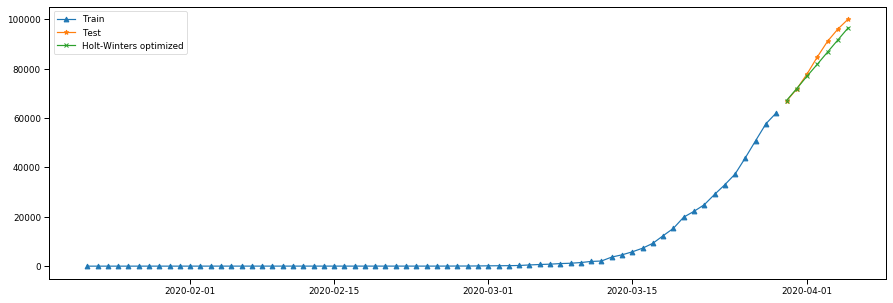

In [96]:
def SDMAE(y_true, y_pred): 
    return mean_absolute_error(y_true, y_pred) / np.std(y_true)

List = df_ml_confirmed.loc[(df_ml_confirmed.Province_and_country == "Germany")]

List.index = List['Date']
#List = List.reset_index(drop=True)

train = List.loc[List.Date <= split_date]
test = List.loc[List.Date > split_date]

train = train.fillna(0)
test = test.fillna(0)

train = pd.DataFrame(train['Confirmed'])
test = pd.DataFrame(test['Confirmed'])

model = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=6, damped=False) #Tuned_model

hw_model = model.fit(optimized=True, use_boxcox=False, remove_bias=True) #base_model

pred = hw_model.predict(start=test.index[0], end=test.index[-1])
pred = pd.DataFrame(pred)
pred.rename(columns={ pred.columns[0]: "Confirmed" }, inplace = True)

plt.plot(train.index, train, label='Train',marker ='^')
plt.plot(test.index, test, label='Test', marker = "*")
plt.plot(test.index, pred, label='Holt-Winters optimized', marker = "x")
plt.legend(loc='best')

print(mean_absolute_error(y_pred=pred, y_true=test))
print(np.sqrt(mean_absolute_error(y_pred=pred, y_true=test)))
print(SDMAE(y_pred=pred.Confirmed, y_true=test.Confirmed))

#['add', False, 'add', 6, False, True]
# t1,d1,s1,p1,b1,r1

4409.714285714285
66.40567961939917
0.3811255975977822


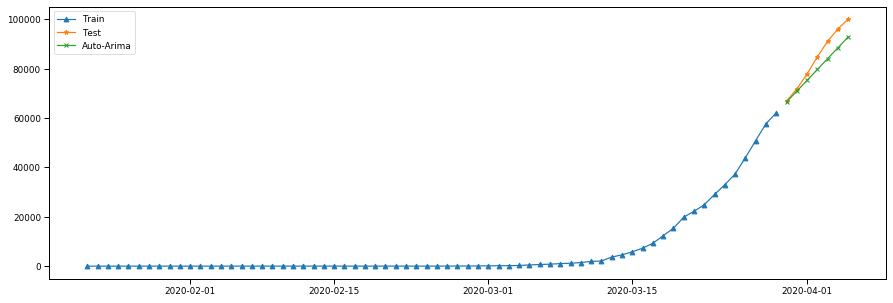

In [97]:
def SDMAE(y_true, y_pred): 
    return mean_absolute_error(y_true, y_pred) / np.std(y_true)

List = df_ml_confirmed.loc[(df_ml_confirmed.Province_and_country == "Germany")]

List.index = List['Date']
#List = List.reset_index(drop=True)

train = List.loc[List.Date <= split_date]
test = List.loc[List.Date > split_date]

train = train.fillna(0)
test = test.fillna(0)

train = pd.DataFrame(train['Confirmed'])
test = pd.DataFrame(test['Confirmed'])

stepwise_fit = auto_arima(train, error_action='ignore', trace=False,
                      suppress_warnings=True, maxiter=100,
                      seasonal=True, stepwise=True)  # set to stepwise

stepwise_fit.summary()

pred = pd.DataFrame(stepwise_fit.predict(n_periods=7), index= test.index)

pred.columns = ['Confirmed']

plt.plot(train.index, train, label='Train',marker ='^')
plt.plot(test.index, test, label='Test', marker = "*")
plt.plot(test.index, pred, label='Auto-Arima', marker = "x")
plt.legend(loc='best')

print(mean_absolute_error(y_pred=pred, y_true=test))
print(np.sqrt(mean_absolute_error(y_pred=pred, y_true=test)))
print(SDMAE(y_pred=pred.Confirmed, y_true=test.Confirmed))

### All customers

In [98]:
df_ml_confirmed_var = pd.DataFrame(list(dict.fromkeys(df_ml_confirmed.Province_and_country)))
df_ml_confirmed_var.rename(columns={ df_ml_confirmed_var.columns[0]: "Value" }, inplace = True)
#df_ml_confirmed_var = df_ml_confirmed_var.loc[(df_ml_confirmed_var.Value == "Germany")]
#df_ml_confirmed_var = df_ml_confirmed_var.head(20)

#### Linear Regression

In [99]:
#Training and Test
def SDMAE(y_true, y_pred): 
    return mean_absolute_error(y_true, y_pred) / np.std(y_true)

Train_and_Test_temp = []

for i in tqdm(df_ml_confirmed_var.Value):
    
    List = df_ml_confirmed.loc[(df_ml_confirmed.Province_and_country == i)]
    
    Confirmed_train = List.loc[List.Date <= split_date].copy()
    Confirmed_test = List.loc[List.Date > split_date].copy()
    
    X_train, y_train = create_x_y(Confirmed_train, label='Confirmed')
    X_test, y_test = create_x_y(Confirmed_test, label='Confirmed')

    X_train = X_train.fillna(0)
    X_test = X_test.fillna(0)

    linear_regressor = LinearRegression(fit_intercept=False)  # create object for the class

    linear_regressor.fit(X_train, y_train)

    Confirmed_test['Confirmed_Prediction'] = linear_regressor.predict(X_test)
    
    Confirmed_test['File_type'] = "Test"
    Confirmed_train['File_type'] = "Train"
    
    Train_and_Test_ = pd.concat([Confirmed_test, Confirmed_train], axis=0, sort=False)
    
    Train_and_Test_['Model'] = "Linear Regression"
    
    Train_and_Test_['MAE'] = mean_absolute_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed'])

    Train_and_Test_['RMSE'] = np.sqrt(mean_absolute_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed']))
    
    Train_and_Test_['SDMAE'] = SDMAE(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed'])
    
    Train_and_Test_temp.append(Train_and_Test_)
    
print("Finished!")

Train_and_Test_Linear = pd.concat(Train_and_Test_temp)
Train_and_Test = pd.concat(Train_and_Test_temp)


Finished!


In [100]:
Train_and_Test_Linear = Train_and_Test_Linear.replace([np.inf, -np.inf], np.nan)
print(mean(Train_and_Test_Linear.loc[Train_and_Test_Linear.MAE.notnull(), 'MAE']))
print(mean(Train_and_Test_Linear.loc[Train_and_Test_Linear.RMSE.notnull(), 'RMSE']))
print(mean(Train_and_Test_Linear.loc[Train_and_Test_Linear.SDMAE.notnull(), 'SDMAE']))

1611.163509644468
17.46623775871093
91.57426893598111


#### Holt-Winters (non-optimized)

In [101]:
#Training and Test
def SDMAE(y_true, y_pred): 
    return mean_absolute_error(y_true, y_pred) / np.std(y_true)

Train_and_Test_temp = []

for i in tqdm(df_ml_confirmed_var.Value):
    
    List = df_ml_confirmed.loc[(df_ml_confirmed.Province_and_country == i)]
    
    List.index = List['Date']

    Confirmed_train = List.loc[List.Date <= split_date]
    Confirmed_test = List.loc[List.Date > split_date]

    Confirmed_train = Confirmed_train.fillna(0)
    Confirmed_test = Confirmed_test.fillna(0)

    Confirmed_train_ = pd.DataFrame(Confirmed_train['Confirmed'])
    Confirmed_test_ = pd.DataFrame(Confirmed_test['Confirmed'])

    model = ExponentialSmoothing(Confirmed_train_, trend='add', seasonal='add', seasonal_periods=12, damped=False) #base_model
    hw_model = model.fit(optimized=True, use_boxcox=False, remove_bias=True) #base_model

    Confirmed_test['Confirmed_Prediction'] = hw_model.predict(start=test.index[0], end=test.index[-1])
    
    Confirmed_test['File_type'] = "Test"
    Confirmed_train['File_type'] = "Train"
    
    Train_and_Test_ = pd.concat([Confirmed_test, Confirmed_train], axis=0, sort=False)
    
    Train_and_Test_['Model'] = "Holt-Winters Non-optimized"
    
    Train_and_Test_['MAE'] = mean_absolute_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed'])

    Train_and_Test_['RMSE'] = np.sqrt(mean_absolute_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed']))
    
    Train_and_Test_['SDMAE'] = SDMAE(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed'])
    
    Train_and_Test_temp.append(Train_and_Test_)
    
print("Finished!")

Train_and_Test_Holt = pd.concat(Train_and_Test_temp)
Train_and_Test = Train_and_Test.append(Train_and_Test_Holt)


Finished!


In [102]:
Train_and_Test_Holt = Train_and_Test_Holt.replace([np.inf, -np.inf], np.nan)
print(mean(Train_and_Test_Holt.loc[Train_and_Test_Holt.MAE.notnull(), 'MAE']))
print(mean(Train_and_Test_Holt.loc[Train_and_Test_Holt.RMSE.notnull(), 'RMSE']))
print(mean(Train_and_Test_Holt.loc[Train_and_Test_Holt.SDMAE.notnull(), 'SDMAE']))

293.09436506739564
7.974494208018214
11.400649349961869


#### Holt-Winters (optimized)

In [103]:
#Training and Test
def SDMAE(y_true, y_pred): 
    return mean_absolute_error(y_true, y_pred) / np.std(y_true)

Train_and_Test_temp = []

for i in tqdm(df_ml_confirmed_var.Value):
    
    List = df_ml_confirmed.loc[(df_ml_confirmed.Province_and_country == i)]
    
    List.index = List['Date']

    Confirmed_train = List.loc[List.Date <= split_date]
    Confirmed_test = List.loc[List.Date > split_date]

    Confirmed_train = Confirmed_train.fillna(0)
    Confirmed_test = Confirmed_test.fillna(0)

    Confirmed_train_ = pd.DataFrame(Confirmed_train['Confirmed'])
    Confirmed_test_ = pd.DataFrame(Confirmed_test['Confirmed'])

    model = ExponentialSmoothing(train, trend='add', seasonal='None', seasonal_periods=6, damped=True) #Tuned_model
    hw_model = model.fit(optimized=True, use_boxcox=False, remove_bias=True) #base_model

    Confirmed_test['Confirmed_Prediction'] = hw_model.predict(start=test.index[0], end=test.index[-1])
    
    Confirmed_test['File_type'] = "Test"
    Confirmed_train['File_type'] = "Train"
    
    Train_and_Test_ = pd.concat([Confirmed_test, Confirmed_train], axis=0, sort=False)
    
    Train_and_Test_['Model'] = "Holt-Winters Optimized"
    
    Train_and_Test_['MAE'] = mean_absolute_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed'])

    Train_and_Test_['RMSE'] = np.sqrt(mean_absolute_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed']))
    
    Train_and_Test_['SDMAE'] = SDMAE(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed'])
    
    Train_and_Test_temp.append(Train_and_Test_)
    
print("Finished!")

Train_and_Test_Holt_optimized = pd.concat(Train_and_Test_temp)
Train_and_Test = Train_and_Test.append(Train_and_Test_Holt_optimized)


Finished!


In [104]:
Train_and_Test_Holt_optimized = Train_and_Test_Holt_optimized.replace([np.inf, -np.inf], np.nan)
print(mean(Train_and_Test_Holt_optimized.loc[Train_and_Test_Holt_optimized.MAE.notnull(), 'MAE']))
print(mean(Train_and_Test_Holt_optimized.loc[Train_and_Test_Holt_optimized.RMSE.notnull(), 'RMSE']))
print(mean(Train_and_Test_Holt_optimized.loc[Train_and_Test_Holt_optimized.SDMAE.notnull(), 'SDMAE']))

79516.00251925856
280.8787500572811
27469.0547383951


#### Auto-ARIMA

In [105]:
#Training and Test
def SDMAE(y_true, y_pred): 
    return mean_absolute_error(y_true, y_pred) / np.std(y_true)

Train_and_Test_temp = []

for i in tqdm(df_ml_confirmed_var.Value):
    
    List = df_ml_confirmed.loc[(df_ml_confirmed.Province_and_country == i)]
    
    List.index = List['Date']

    Confirmed_train = List.loc[List.Date <= split_date]
    Confirmed_test = List.loc[List.Date > split_date]

    Confirmed_train = Confirmed_train.fillna(0)
    Confirmed_test = Confirmed_test.fillna(0)

    Confirmed_train_ = pd.DataFrame(Confirmed_train['Confirmed'])
    Confirmed_test_ = pd.DataFrame(Confirmed_test['Confirmed'])

    stepwise_fit = auto_arima(Confirmed_train_, error_action='ignore', trace=False,
                      suppress_warnings=True, maxiter=100,
                      seasonal=True, stepwise=True)  # set to stepwise

    stepwise_fit.summary()

    Confirmed_test['Confirmed_Prediction'] = pd.DataFrame(stepwise_fit.predict(n_periods=7), index= Confirmed_test_.index)
    
    Confirmed_test['File_type'] = "Test"
    Confirmed_train['File_type'] = "Train"
    
    Train_and_Test_ = pd.concat([Confirmed_test, Confirmed_train], axis=0, sort=False)
    
    Train_and_Test_['Model'] = "Auto-ARIMA"
    
    Train_and_Test_['MAE'] = mean_absolute_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed'])

    Train_and_Test_['RMSE'] = np.sqrt(mean_absolute_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed']))
    
    Train_and_Test_['SDMAE'] = SDMAE(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed'])
    
    Train_and_Test_temp.append(Train_and_Test_)
    
print("Finished!")

Train_and_Test_ARIMA = pd.concat(Train_and_Test_temp)
Train_and_Test = Train_and_Test.append(Train_and_Test_ARIMA)


Finished!


In [106]:
Train_and_Test_ARIMA = Train_and_Test_ARIMA.replace([np.inf, -np.inf], np.nan)
print(mean(Train_and_Test_ARIMA.loc[Train_and_Test_ARIMA.MAE.notnull(), 'MAE']))
print(mean(Train_and_Test_ARIMA.loc[Train_and_Test_ARIMA.RMSE.notnull(), 'RMSE']))
print(mean(Train_and_Test_ARIMA.loc[Train_and_Test_ARIMA.SDMAE.notnull(), 'SDMAE']))

215.0898896880941
7.692820508165952
1.5603044642616888


In [107]:
Train_and_Test['Update_date'] = datetime.today()

In [108]:
Train_and_Test.to_csv('Train_and_Test.CSV',sep=',')